In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# import data
input_df = pd.read_csv('.\\data\\model_input.csv', index_col=0)
input_df = input_df.iloc[:, 1:17].reset_index(drop=True)
input_df.head()

,P-TPT_min,P-TPT_max,P-TPT_avg,P-TPT_median,P-TPT_std,P-TPT_skew,P-TPT_kurtosis,class,Well,T-TPT_min,T-TPT_max,T-TPT_avg,T-TPT_median,T-TPT_std,T-TPT_skew,T-TPT_kurtosis
0,10074140.0,10094480.0,1.007721e+07,10074540.0,5209.312742,1.833867,2.013847,0,1,119.0202,119.0983,119.071595,119.09460,0.030666,-0.644713,-1.368589
1,10054590.0,10074540.0,1.005869e+07,10054590.0,6934.029502,1.397679,0.325582,0,1,119.0289,119.0816,119.053798,119.05295,0.015037,0.139920,-1.137372
2,10054590.0,10074540.0,1.006806e+07,10074540.0,8691.019859,-0.741157,-1.315182,0,1,119.0202,119.0983,119.052313,119.03720,0.028058,0.481393,-1.525810
3,10054590.0,10094480.0,1.007383e+07,10075870.0,12058.096512,-0.200505,-1.196607,0,1,119.0074,119.0593,119.047137,119.05010,0.012727,-1.324615,1.187340
4,9994737.0,10094480.0,1.004313e+07,10033905.0,33898.027444,0.154115,-1.517661,0,1,118.9811,119.0796,119.000756,118.98400,0.027312,1.284583,0.406179


In [4]:
input_df.groupby(['Well', 'class'])['P-TPT_min'].count()

Well  class
1     0         674
      4         146
2     0        2040
      4         452
3     0         260
4     0          48
      4         172
5     0         550
      4         152
6     0        1150
7     0           8
      4          40
8     0         570
10    4         332
14    4          84
Name: P-TPT_min, dtype: int64

In [5]:
input_df.shape

(6678, 16)

<AxesSubplot:>

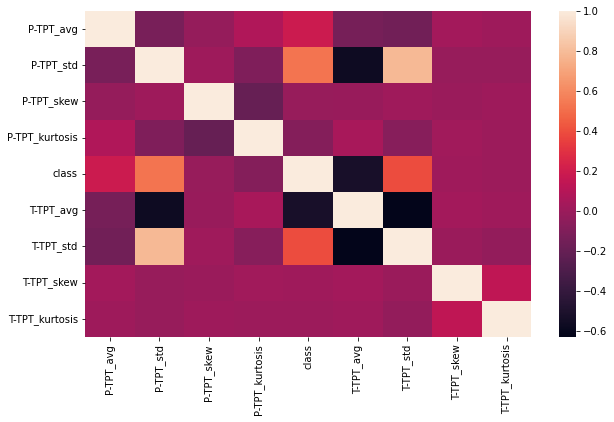

In [6]:
import seaborn as sns

predictors = [x for x in input_df.columns if x not in ['Well', 'P-TPT_min', 'P-TPT_max', 'P-TPT_median', 'T-TPT_min', 'T-TPT_max', 'T-TPT_median']]
plt.figure(figsize=(10, 6))
corr = input_df[predictors].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [7]:
train_wells = [1, 2, 3, 4, 5, 6]
test_wells = [7, 8, 10, 14]

#_X = input_df[['P-TPT_min', 'P-TPT_max', 'P-TPT_avg', 'P-TPT_median', 'P-TPT_std', 'P-TPT_skew', 'P-TPT_kurtosis', 'class', 'Well', 'T-TPT_min', 'T-TPT_max', 'T-TPT_avg', 'T-TPT_median', 'T-TPT_std', 'T-TPT_skew']]
train_idx = input_df['Well'].isin(train_wells)
test_idx = input_df['Well'].isin(test_wells)

from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
X = input_df[predictors].drop(['class'], axis=1)
Y = input_df['class']
Y = Y.replace(4, 1)
print(set(Y))

_X = scaler.fit_transform(X)

X_train = _X[train_idx, :]
X_test = _X[test_idx, :]
Y_train = Y[train_idx]
Y_test = Y[test_idx]

print(f"train data set contains {X_train.shape[0]} observations")
print(f"training set has {len(Y_train[Y_train==0])} observations of class 0 and {len(Y_train[Y_train==1])} of class 4")
print(f"test data set contains {X_test.shape[0]} observations")
print(f"training set has {len(Y_test[Y_test==0])} observations of class 0 and {len(Y_test[Y_test==1])} of class 4")




{0, 1}
train data set contains 5644 observations
training set has 4722 observations of class 0 and 922 of class 4
test data set contains 1034 observations
training set has 578 observations of class 0 and 456 of class 4


In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7).fit(_X)
print(np.cumsum(pca.explained_variance_ratio_))

_X_pca = pca.fit_transform(_X)

[0.29458264 0.44798886 0.59033324 0.72098744 0.82864393 0.92690234
 0.97455661]


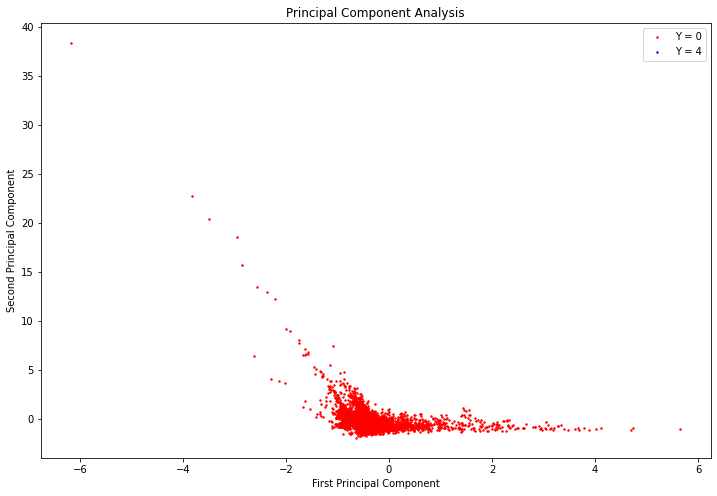

In [9]:


plt.figure(figsize=(12, 8))
plt.scatter(_X_pca[Y == 0, 0], _X_pca[Y == 0, 1], color='r', label='Y = 0', s=2)
plt.scatter(_X_pca[Y == 4, 0], _X_pca[Y == 4, 1], color='b', label='Y = 4', s=2)
plt.title('Principal Component Analysis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score

# random forest
n_trees = np.linspace(30, 300, num=10)
param = {'n_estimators': [int(x) for x in n_trees]}
clf = RandomForestClassifier(random_state=42, warm_start=True)
#scorer = precision_score(pos_label=4)
cv = GridSearchCV(clf, param, cv=10, verbose=1, scoring='precision')
cv.fit(X_train, Y_train.ravel())
#print(cv.cv_results_)
print(f"best score of {cv.best_score_} with {list(param.keys())[0]} = {cv.best_params_[list(param.keys())[0]]}")
clf.set_params(**cv.best_params_)
clf.fit(X_train, Y_train.ravel())
y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, y_pred))
print(classification_report(Y_test.ravel(), y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best score of 0.9241679203050076 with n_estimators = 270
(array([0.82571429, 1.        ]), array([1.        , 0.73245614]), array([0.90453834, 0.84556962]), array([578, 456], dtype=int64))
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       578
           1       1.00      0.73      0.85       456

    accuracy                           0.88      1034
   macro avg       0.91      0.87      0.88      1034
weighted avg       0.90      0.88      0.88      1034



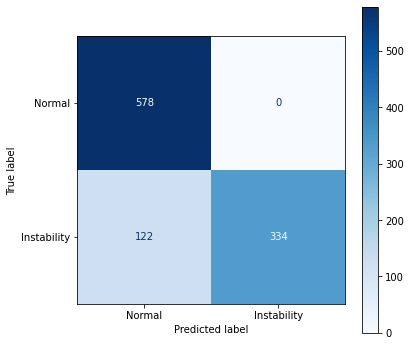

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(Y_test.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Instability'])
disp.plot(ax=ax, cmap='Blues')

In [12]:
cv.cv_results_

{'mean_fit_time': array([0.17405713, 0.31249344, 0.50813978, 0.68226733, 0.84509003,
        0.94639678, 1.28484938, 1.46586015, 1.56278274, 1.73554223]),
 'std_fit_time': array([0.02457233, 0.03072149, 0.11561869, 0.06684791, 0.08999392,
        0.09568522, 0.13926312, 0.13831951, 0.17730419, 0.18906638]),
 'mean_score_time': array([0.00848258, 0.0094269 , 0.01439946, 0.01684158, 0.0184123 ,
        0.02025454, 0.02912791, 0.03285892, 0.03903196, 0.03329537]),
 'std_score_time': array([0.00852355, 0.00226945, 0.0040029 , 0.00768553, 0.00657204,
        0.00594603, 0.00841249, 0.00796511, 0.01426963, 0.00711802]),
 'param_n_estimators': masked_array(data=[30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 30},
  {'n_estimators': 60},
  {'n_estimators': 90},
  {'n_estimators': 120},
  {'n_estimators':

Text(0, 0.5, 'Precision')

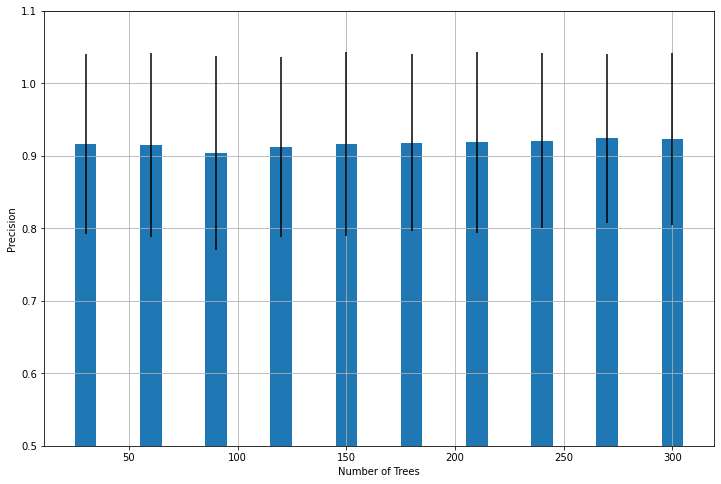

In [13]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.bar(n_trees, cv.cv_results_['mean_test_score'], yerr=cv.cv_results_['std_test_score'], width=10)
plt.ylim((0.5, 1.1))
plt.xlabel('Number of Trees')
plt.ylabel('Precision')

c:\Users\Tom Swarbrick\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


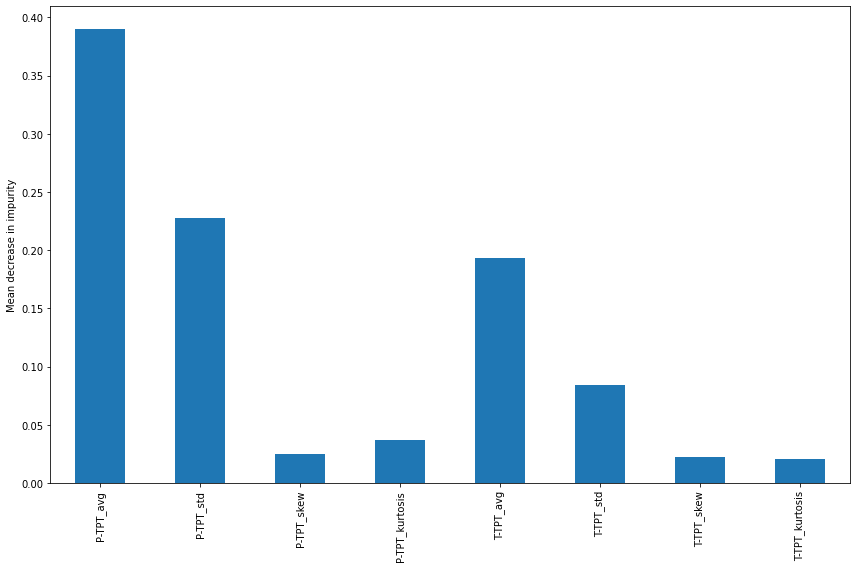

In [14]:
clf.fit(X_train, Y_train.ravel())
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
fig.add_gridspec()
fig.set_figwidth(12)
fig.set_figheight(8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
# naive bayes
clf = GaussianNB()
clf.fit(X_train, Y_train.ravel())
y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, y_pred))
print(classification_report(Y_test.ravel(), y_pred))

(array([1.        , 0.98275862]), array([0.98615917, 1.        ]), array([0.99303136, 0.99130435]), array([578, 456], dtype=int64))
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       578
           1       0.98      1.00      0.99       456

    accuracy                           0.99      1034
   macro avg       0.99      0.99      0.99      1034
weighted avg       0.99      0.99      0.99      1034



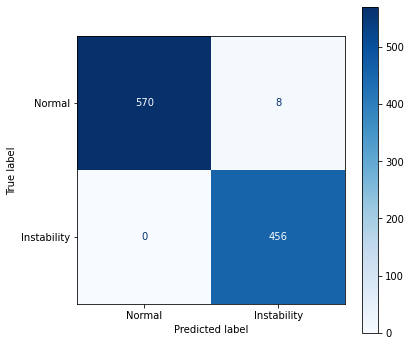

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(Y_test.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Instability'])
disp.plot(ax=ax, cmap='Blues')

In [28]:
# logistic regression
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression(random_state=42)
#scorer = precision_score(pos_label=4)
cv = GridSearchCV(clf, param, cv=10, verbose=1, scoring='precision')
cv.fit(X_train, Y_train.ravel())
#print(cv.cv_results_)
print(f"best score of {cv.best_score_} with {list(param.keys())[0]} = {cv.best_params_[list(param.keys())[0]]}")
clf.set_params(**cv.best_params_)
clf.fit(X_train, Y_train.ravel())
y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, y_pred))
print(classification_report(Y_test.ravel(), y_pred))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


c:\Users\Tom Swarbrick\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tom Swarbrick\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tom Swarbrick\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

best score of 0.3752147174556813 with C = 100
(array([0.83649635, 0.98567335]), array([0.99134948, 0.75438596]), array([0.90736342, 0.85465839]), array([578, 456], dtype=int64))
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       578
           1       0.99      0.75      0.85       456

    accuracy                           0.89      1034
   macro avg       0.91      0.87      0.88      1034
weighted avg       0.90      0.89      0.88      1034



Text(0, 0.5, 'Precision')

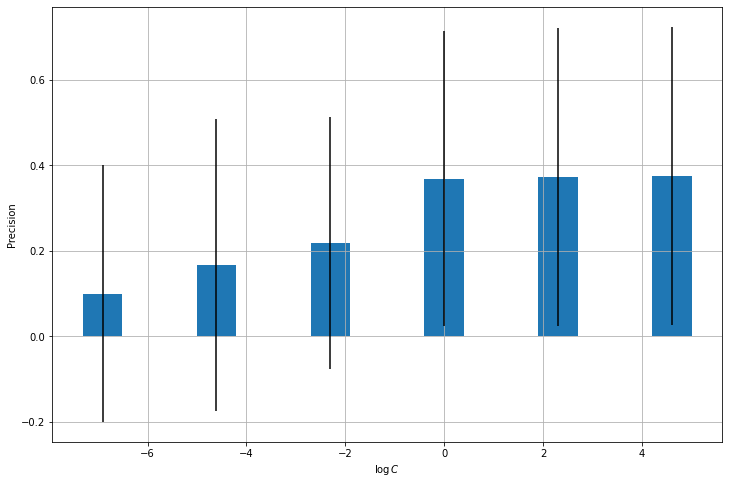

In [30]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.bar(np.log([0.001, 0.01, 0.1, 1, 10, 100]), cv.cv_results_['mean_test_score'], yerr=cv.cv_results_['std_test_score'])
plt.xlabel('$\log C$')
plt.ylabel('Precision')

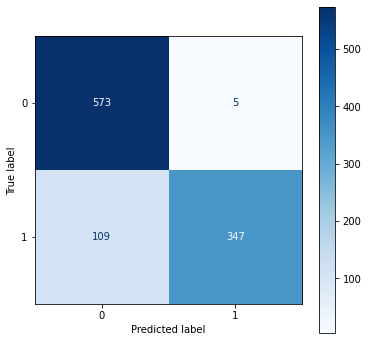

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(Y_test.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues')

In [20]:
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier(random_state=42)
selector = RFECV(estimator=clf, min_features_to_select=5, verbose=0)
selector = selector.fit(X_train, Y_train)
 
selector.support_


array([ True,  True,  True,  True,  True,  True,  True,  True])

In [21]:
best_features = pd.DataFrame({'Rank': selector.ranking_, 'Feature': X.columns})
best_features


,Rank,Feature
0,1,P-TPT_avg
1,1,P-TPT_std
2,1,P-TPT_skew
3,1,P-TPT_kurtosis
4,1,T-TPT_avg
5,1,T-TPT_std
6,1,T-TPT_skew
7,1,T-TPT_kurtosis
